# Groupe 3 : Projet Machine Learning

## Introduction

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk

In [74]:
dataset = pd.read_csv('scitweets_export.tsv', sep='\t')
dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


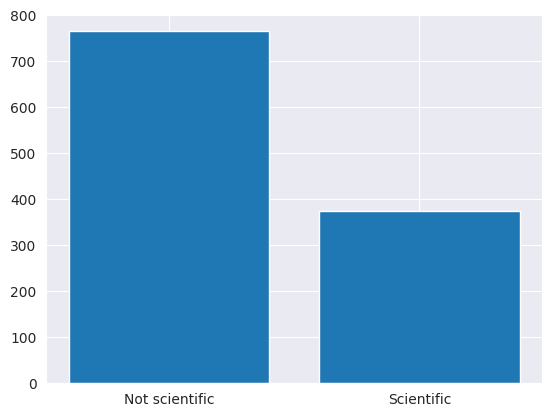

In [75]:
not_scientific = dataset.where(dataset['science_related'] == 0)
scientific = dataset.where(dataset['science_related'] == 1)

fig, ax = plt.subplots()
ax.bar(['Not scientific', 'Scientific'], [not_scientific['tweet_id'].count(), scientific['tweet_id'].count()])
plt.show()

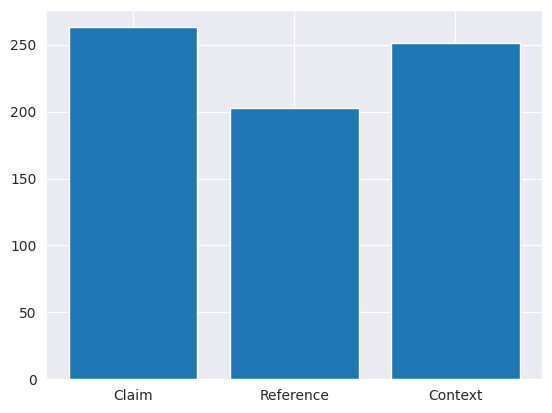

In [76]:
fig, ax = plt.subplots()
ax.bar(['Claim', "Reference", "Context"],
       [scientific.where(scientific['scientific_claim'] == 1)['tweet_id'].count(),
        scientific.where(scientific['scientific_reference'] == 1)['tweet_id'].count(),
        scientific.where(scientific['scientific_context'] == 1)['tweet_id'].count()])
plt.show()

## Prétraitement

On met tout en minuscule

In [77]:
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,can any gynecologist with cancer experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,does daily routine help prevent problems with ...,1,1.0,0.0,0.0


### Lemmatization

download the packages

In [78]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Downloading package punkt to /home/raphael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raphael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raphael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Remove the stopwords but not the negation words or the words that are important for the sentiment analysis

In [79]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
work_to_keep = ['no', 'not', 'nor', 'too', 'very', 'against', 'but', 'don', 'don\'t', 'ain', 'aren', 'aren\'t', 'couldn', 'couldn\'t', 'didn', 'didn\'t', 'doesn', 'doesn\'t', 'hadn', 'hadn\'t', 'hasn', 'hasn\'t', 'haven', 'haven\'t', 'isn', 'isn\'t', 'mightn', 'mightn\'t', 'mustn', 'mustn\'t', 'needn', 'needn\'t', 'shan', 'shan\'t', 'shouldn', 'shouldn\'t', 'wasn', 'wasn\'t', 'weren', 'weren\'t', 'won', 'won\'t', 'wouldn', 'wouldn\'t']

for word in work_to_keep:
    stop_words.remove(word)

dataset['text'] = dataset['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore. guess that's sign recent tread...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch-lock highs lead sleeping couch. gotta st...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Remove the links

In [80]:
for index, line in dataset.iterrows():
    splitted = line['text'].split(' ')
    new_text = []
    for word in splitted:
        if 'http' in word or 'www' in word:
            continue
        new_text.append(word)
    dataset.at[index, 'text'] = ' '.join(new_text)

dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore. guess that's sign recent tread...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch-lock highs lead sleeping couch. gotta st...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Transform the emojis into text

In [81]:
import emoji

# Parcourir les indices et modifier directement les valeurs dans le DataFrame
for index, line in dataset.iterrows():
    dataset.at[index, 'text'] = emoji.demojize(line['text'])

# Afficher les premières lignes du DataFrame pour vérifier les modifications
dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore. guess that's sign recent tread...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym :basketball::fle...,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch-lock highs lead sleeping couch. gotta st...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Remove the non-alphabetic characters except the #

In [82]:
for index, line in dataset.iterrows():
    splitted = line['text'].split(' ')
    new_text = []
    for word in splitted:
        new_word = ""
        for l in word:
            if l.isalpha() or l in ['#', "'", '?', '!'] :
                new_word += l
            else:
                new_word += ' '
        new_text.append(new_word)
    dataset.at[index, 'text'] = ' '.join(new_text)

dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore guess that's sign recent tread...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym basketball fle...,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch lock highs lead sleeping couch gotta st...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Remove multiple spaces

In [83]:
for index, line in dataset.iterrows():
    dataset.at[index, 'text'] = ' '.join(line['text'].split())

dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore guess that's sign recent treadm...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym basketball flexe...,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch lock highs lead sleeping couch gotta sto...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


In [ ]:
scientific = dataset.where(dataset['science_related'] == 1)
not_scientific = dataset.where(dataset['science_related'] == 0)

# calcul de la fréquence des mots
from collections import Counter

def get_freq_words(data):
    freq_words = Counter()
    for index, line in data.iterrows():
        for word in line['text'].split():
            freq_words[word] += 1
    return freq_words

freq_scientific = get_freq_words(scientific)
freq_not_scientific = get_freq_words(not_scientific)



## Vectorisation des textes

(TF-IDF)

## Choix des modèles